# Creating a stream vector shapefile

pyGSFLOW includes capabilities for converting a discretized `SFR` stream network to a vector based shapefile. The attribute tabble of this shapefile contains information on each vector's connectivity and can be used to parameterize MODSIM models.

The `Modsim` class in pyGSFLOW calculates stream segment connectivity to other segments and to lakes parameterized in the `LAK` package.

In [1]:
# start with importing our packages
import os
import sys
import flopy as fp
import gsflow 
import matplotlib.pyplot as plt
import numpy as np
import shapefile
import pandas as pd

In [2]:
# define our model workspace and spatial information
ws = os.path.abspath(os.path.dirname(sys.argv[0]))
model_ws = os.path.join("data", "sagehen", "gsflow")

xll = 438979.0
yll = 3793007.75
angrot = 4

## Loading a GSFLOW model

Our first step is to load a GSFLOW model using pyGSFLOW. If the `model_mode` parameter is set to `MODSIM-GSFLOW` or `GSFLOW-MODSIM` within the control file, pyGSFLOW will automatically create a stream vector shapefile when the model is written to disk. If the `model_mode` parameter in the GSFLOW control file is `GSFLOW` or `MODFLOW` the user can still create a stream vector shapefile. This example outlines how to create a shapefile in the second case (`model_mode`= `GSFLOW` or `MODFLOW`)

In [3]:
# load the model
gsf = gsflow.GsflowModel.load_from_file(os.path.join(model_ws, 'saghen_new_cont.control'))

# set model grid coordinate info
gsf.mf.modelgrid.set_coord_info(xll, yll, 4)

Control file is loaded
Working on loading PRMS model ...
Prms model loading ...
------------------------------------
Reading parameter file : saghen_new_par_0.params
------------------------------------
------------------------------------
Reading parameter file : saghen_new_par_1.params
------------------------------------
------------------------------------
Reading parameter file : saghen_new_par_2.params
------------------------------------
------------------------------------
Reading parameter file : saghen_new_par_3.params
------------------------------------
PRMS model loaded ...
Working on loading MODFLOW files ....
   loading iuzfbnd array...
   loading irunbnd array...
   loading vks array...
   loading eps array...
   loading thts array...
stress period 1:
   loading finf array...
stress period 2:
MODFLOW files are loaded ... 


Let's plot the stream network from SFR first, just to examine it.

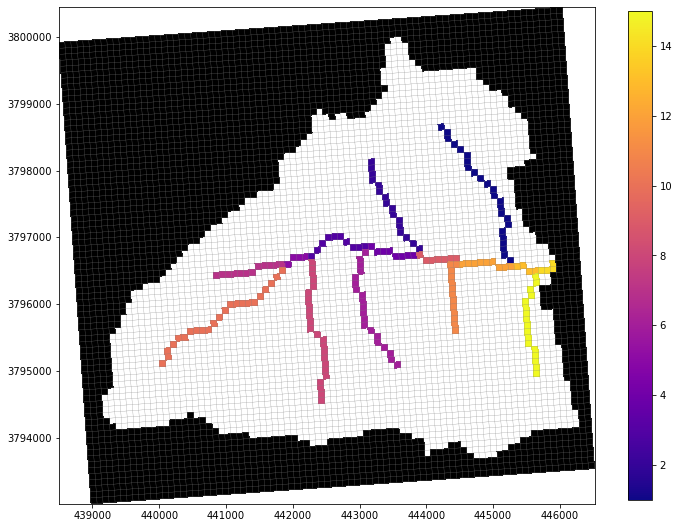

In [4]:
rch = gsf.mf.sfr.reach_data

# set up an array of iseg numbers to visualize connectivity
arr = np.zeros((1, gsf.mf.nrow, gsf.mf.ncol), dtype='int')
for rec in rch:
    arr[0, rec.i, rec.j] = rec.iseg

# use flopy to plot the SFR segments
fig = plt.figure(figsize=(12, 12))
pmv = fp.plot.PlotMapView(model=gsf.mf)
collection = pmv.plot_array(arr, masked_values=[0,], cmap='plasma')
pmv.plot_inactive()
pmv.plot_grid(lw=0.25)
plt.colorbar(collection, shrink=0.75);

## Creating a `Modsim` instance using a `GsflowModel` object

creating a MODSIM instance is as easy as passing a `GsflowModel` object to the `Modsim` class.

In [5]:
# creating a MODSIM instance is as easy as 
modsim = gsflow.modsim.Modsim(gsf)


## Exporting a vector shapefile from `Modsim`

The `Modsim` instance has a built in method `write_modsim_shapefile()` that is used to write a stream vector shapefiles. The `write_modsim_shapefile` has a number of parameters that can be used:

   - `shp`: is a string defining the output shapefile's name
   - `proj4` : proj4 is an optional parameter that can be used to define the shapefile's projection information
   - `flag_spillway` : an optional parameter that can be used to determine spillways in the streamflow network. There are methods that have been implemented  
    + `"elev"` : elevation method which flags based on streambed elevation rules
    + `"flow"` : flag spillways based on flow rules
    + list of segments : the user can provide a list of segments that are known spillways to be flagged
   - `nearest` : boolean value that determines if LAK topology will connect to the nearest reach in a segment or the the begining/end of that segment.

In [6]:
shp_file = os.path.join(ws, "data", "temp", "sagehen_vectors.shp")
modsim.write_modsim_shapefile(shp_file)

modsim.py:361: UserWarning: Please provide a valid proj4 or epsg code to flopy'smodel grid: Skipping writing sagehen_vectors.prj


### Checking the attribute table

Now that the shapefile has been created it can be loaded into GIS software and analyzed. Note: In this example I did not define a projection, and would then need to assign it using my GIS software's tools. 

We can also use pyshp to load the shapefile and inspect it in python.

In [7]:
attr = []
shps = {}
with shapefile.Reader(shp_file) as r:
    fields = [f[0] for i, f in enumerate(r.fields) if i > 0]
    for ix, shape in enumerate(r.shapes()):
        feat = shape.__geo_interface__
        xy = np.array(feat['coordinates']).T
        shps[ix] = xy
        rec = [i for i in r.record(ix)]
        attr.append(rec)

df = pd.DataFrame(attr, columns=fields)
df

,ISEG,IUPSEG,OUTSEG,SPILL_FLG
0,1,0,13,0
1,2,0,9,0
2,3,0,4,0
3,4,0,9,0
4,5,0,3,0
5,6,0,4,0
6,7,0,5,0
7,8,0,3,0
8,9,0,12,0
9,10,0,5,0


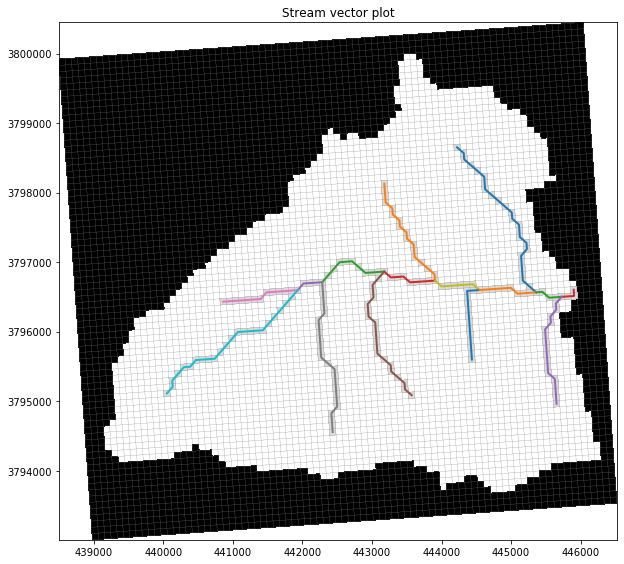

In [8]:
# use flopy to plot the SFR segments
fig = plt.figure(figsize=(10, 10))
pmv = fp.plot.PlotMapView(model=gsf.mf)
# collection = pmv.plot_array(arr, masked_values=[0,], cmap='plasma')
pmv.plot_inactive()
pmv.plot_grid(lw=0.25)
pmv.plot_bc(package=gsf.mf.sfr, color='gainsboro')
for _, xy in shps.items():
    plt.plot(xy[0], xy[1], lw=2)

plt.title("Stream vector plot");

## Modflow instances can also be used to create a vector shapefile

The `Modsim` class can also accept a `flopy.modflow.Modflow` object to create a vector shapefile

In [9]:
ml = fp.modflow.Modflow.load('saghen_new.nam', model_ws=model_ws, version='mfnwt')
ml.modelgrid.set_coord_info(xll, yll, angrot)

modsim = gsflow.modsim.Modsim(ml)

shp_file = os.path.join(ws, "data", "temp", "sagehen_modflow_vectors.shp")
modsim.write_modsim_shapefile(shp_file)

   loading iuzfbnd array...
   loading irunbnd array...
   loading vks array...
   loading eps array...
   loading thts array...
stress period 1:
   loading finf array...
stress period 2:


Inspecting the shapefile:

In [10]:
attr = []
shps = {}
with shapefile.Reader(shp_file) as r:
    fields = [f[0] for i, f in enumerate(r.fields) if i > 0]
    for ix, shape in enumerate(r.shapes()):
        feat = shape.__geo_interface__
        xy = np.array(feat['coordinates']).T
        shps[ix] = xy
        rec = [i for i in r.record(ix)]
        attr.append(rec)

df = pd.DataFrame(attr, columns=fields)
df

,ISEG,IUPSEG,OUTSEG,SPILL_FLG
0,1,0,13,0
1,2,0,9,0
2,3,0,4,0
3,4,0,9,0
4,5,0,3,0
5,6,0,4,0
6,7,0,5,0
7,8,0,3,0
8,9,0,12,0
9,10,0,5,0


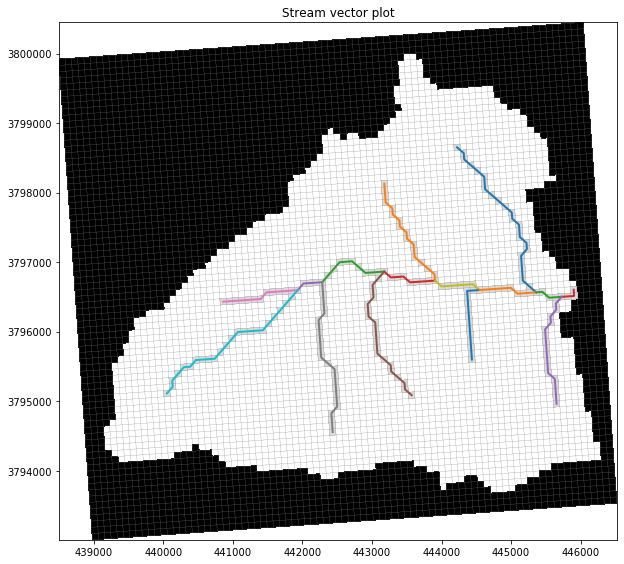

In [11]:
# use flopy to plot the SFR segments
fig = plt.figure(figsize=(10, 10))
pmv = fp.plot.PlotMapView(model=ml)
# collection = pmv.plot_array(arr, masked_values=[0,], cmap='plasma')
pmv.plot_inactive()
pmv.plot_grid(lw=0.25)
pmv.plot_bc(package=ml.sfr, color='gainsboro')
for _, xy in shps.items():
    plt.plot(xy[0], xy[1], lw=2)

plt.title("Stream vector plot");